In [94]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

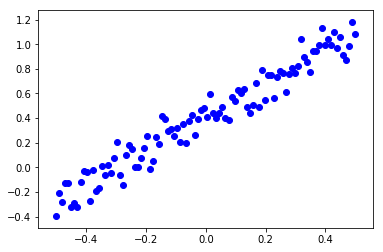

In [95]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [96]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-0.0419906]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 122.95800781]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.0419906]] [[ 122.95800781]]


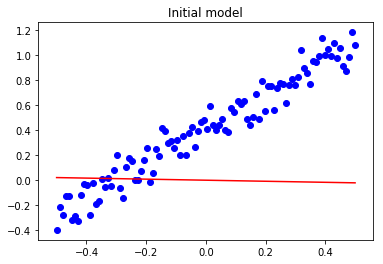

In [97]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes 
# input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [98]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.34495845437049866)
dloss/dW [[-0.23856586]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.3004017174243927)
Itr 25 loss: variable(0.07108345627784729)
Itr 50 loss: variable(0.04035722464323044)
Itr 75 loss: variable(0.02487928606569767)


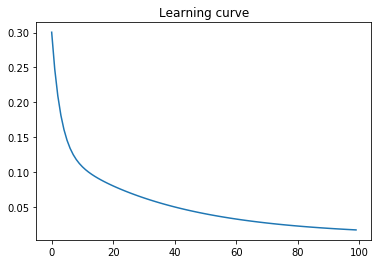

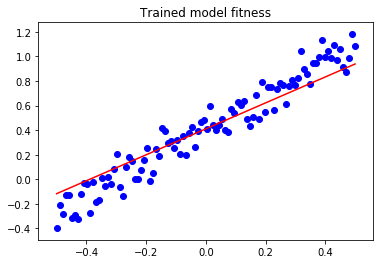

In [99]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

lr = 0.08

for i in range(100):
    model.cleargrads()
    
    model_y = model(data_x[:, None])
    
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    
    loss.backward()

    model.W.data[:]=model.W.data[:]-lr*model.W.grad
    model.b.data[:]=model.b.data[:]-lr*model.b.grad
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


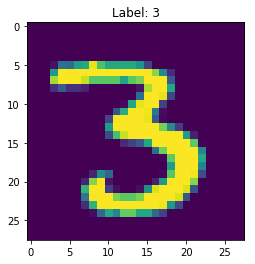

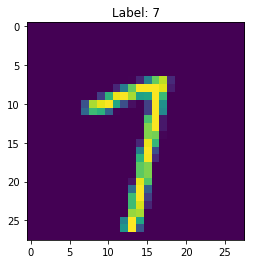

In [100]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [107]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    stats_test = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))
                x_test = np.concatenate([datum[0][None, :] for datum in test])
                y_test = np.array([datum[1] for datum in test])
#                 print(x_test.shape)
                logits_test = model(x_test)

                loss_test = F.softmax_cross_entropy(logits_test, y_test)
                
                stats_test["loss_test"].append(float(loss_test.data))
                stats_test["accuracy_test"].append(float((logits_test.data.argmax(1) == y_test).sum() / x_test.shape[0]))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats_test.items()))
                

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0625; loss: 2.37243390083
accuracy_test: 0.1099; loss_test: 2.29473519325
accuracy: 0.885; loss: 0.556508550644
accuracy_test: 0.4874; loss_test: 1.43382760882
accuracy: 0.8725; loss: 0.503271820545
accuracy_test: 0.6213; loss_test: 1.09979999065
accuracy: 0.8675; loss: 0.474917731285
accuracy_test: 0.69115; loss_test: 0.920684948564
accuracy: 0.8875; loss: 0.413396104574
accuracy_test: 0.73388; loss_test: 0.80780749917
accuracy: 0.8975; loss: 0.339917939603
accuracy_test: 0.763233333333; loss_test: 0.728793253501
accuracy: 0.905; loss: 0.348894730806
accuracy_test: 0.7841; loss_test: 0.671228489705
accuracy: 0.8925; loss: 0.430424574912
accuracy_test: 0.8002125; loss_test: 0.626985758543
accuracy: 0.8875; loss: 0.371588749588
accuracy_test: 0.812822222222; loss_test: 0.591778109471
accuracy: 0.9; loss: 0.372491746843
accuracy_test: 0.82304; loss_test: 0.56299341917
accuracy: 0.94; loss: 0.259090362787
accuracy_test: 0.831327272727; loss_test: 0.539256721735
accuracy: 0.94;

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [102]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        out1 = F.relu(self.l1(x))
        out2 = F.relu(self.l2(out1))
        out3 = self.l3(out2)
        return out3
#         raise NotImplementedError()
run(MLP(200, 10))

accuracy: 0.1875; loss: 2.28345155716
accuracy_test: 0.1947; loss_test: 2.26520442963
accuracy: 0.9125; loss: 0.327069550753
accuracy_test: 0.55125; loss_test: 1.28610476851
accuracy: 0.905; loss: 0.282831045985
accuracy_test: 0.6721; loss_test: 0.950437535842
accuracy: 0.91; loss: 0.2612454772
accuracy_test: 0.739375; loss_test: 0.759144209325
accuracy: 0.95; loss: 0.140617291629
accuracy_test: 0.78166; loss_test: 0.638757491112
accuracy: 0.9475; loss: 0.20359044075
accuracy_test: 0.810866666667; loss_test: 0.556981844207
accuracy: 0.96; loss: 0.118744927049
accuracy_test: 0.830614285714; loss_test: 0.500628120133
accuracy: 0.965; loss: 0.127737160325
accuracy_test: 0.8470875; loss_test: 0.453198674135
accuracy: 0.9375; loss: 0.198069212735
accuracy_test: 0.859366666667; loss_test: 0.417441178527
accuracy: 0.9475; loss: 0.175675126016
accuracy_test: 0.86949; loss_test: 0.388545822352
accuracy: 0.9675; loss: 0.125985425115
accuracy_test: 0.878272727273; loss_test: 0.363075687127
accura

Next you should try to implement logging test loss and see if the model is overfitting.

In [103]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    stats_test = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
#                 test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
#                 print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))
                x_test = np.concatenate([datum[0][None, :] for datum in test])
                y_test = np.array([datum[1] for datum in test])
#                 print(x_test.shape)
                logits_test = model(x_test)

                loss_test = F.softmax_cross_entropy(logits_test, y_test)
                
                stats_test["loss_test"].append(float(loss_test.data))
                stats_test["accuracy_test"].append(float((logits_test.data.argmax(1) == y_test).sum() / x_test.shape[0]))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats_test.items()))

better_run(MLP(200, 10))

accuracy_test: 0.1363; loss_test: 2.27495455742
accuracy_test: 0.5058; loss_test: 1.32356718183
accuracy_test: 0.6453; loss_test: 0.963079541922
accuracy_test: 0.719725; loss_test: 0.769475065172
accuracy_test: 0.76606; loss_test: 0.647280606627
accuracy_test: 0.795033333333; loss_test: 0.571287463109
accuracy_test: 0.817485714286; loss_test: 0.51134335569
accuracy_test: 0.8349625; loss_test: 0.463440630585
accuracy_test: 0.848611111111; loss_test: 0.426674632563
accuracy_test: 0.85984; loss_test: 0.397384820879
accuracy_test: 0.869290909091; loss_test: 0.371946102516
accuracy_test: 0.877466666667; loss_test: 0.349468545367
accuracy_test: 0.883984615385; loss_test: 0.331622787393
accuracy_test: 0.889664285714; loss_test: 0.315997939025
accuracy_test: 0.894873333333; loss_test: 0.301473552485
accuracy_test: 0.898775; loss_test: 0.290809827391
accuracy_test: 0.902988235294; loss_test: 0.278682853807
accuracy_test: 0.906466666667; loss_test: 0.269461661991
accuracy_test: 0.909663157895; l

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc